In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# 创建数据集
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_informative=2, random_state=1, n_clusters_per_class=1)
X = StandardScaler().fit_transform(X)
y = y.reshape(-1, 1)

# 转换为张量
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 拆分数据
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


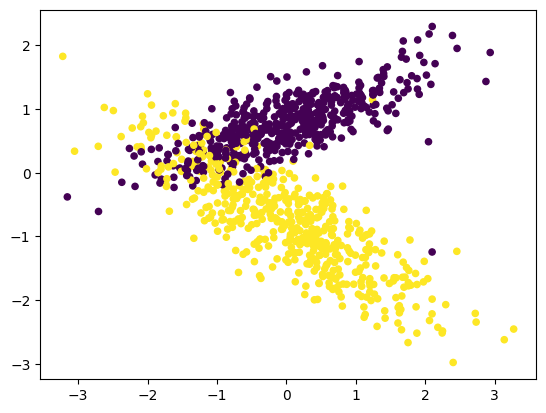

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)

In [17]:
# 定义逻辑回归模型
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# 训练函数
def train_model(loss_fn):
    model = LogisticRegression()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    losses = []

    for epoch in range(100):
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return model,losses

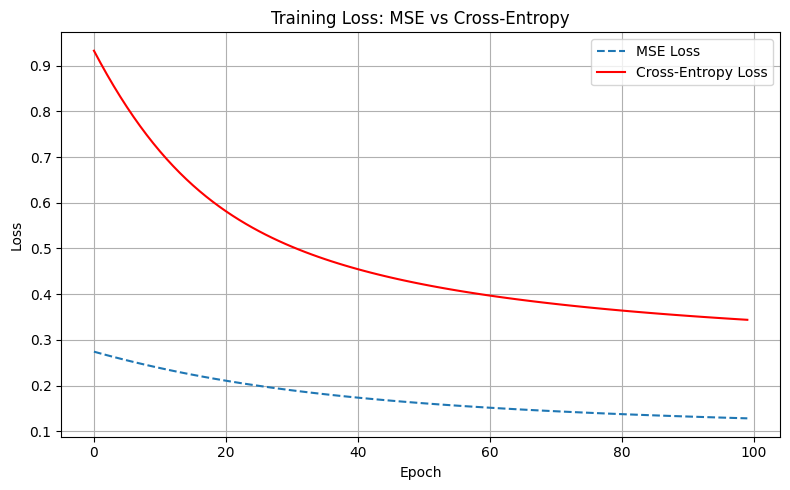

In [18]:
# MSE 和 BCE（交叉熵）损失
mse_loss_fn = nn.MSELoss()
bce_loss_fn = nn.BCELoss()

# 训练模型
mse_model, mse_losses = train_model(mse_loss_fn)
bce_model, bce_losses = train_model(bce_loss_fn)

# 绘图对比
plt.figure(figsize=(8, 5))
plt.plot(mse_losses, label="MSE Loss", linestyle="--")
plt.plot(bce_losses, label="Cross-Entropy Loss", color="red")
plt.title("Training Loss: MSE vs Cross-Entropy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# 对比两种loss在测试集上的分类效果
def plot_decision_boundary(model, X, y, title):
    plt.figure(figsize=(8, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.01),
                             torch.arange(y_min, y_max, 0.01))
    grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)
    with torch.no_grad():
        probs = model(grid).reshape(xx.shape)
    plt.contourf(xx.numpy(), yy.numpy(), probs.numpy(), alpha=0.8)
    plt.title(title)
    plt.show()

c:\Users\wiselaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


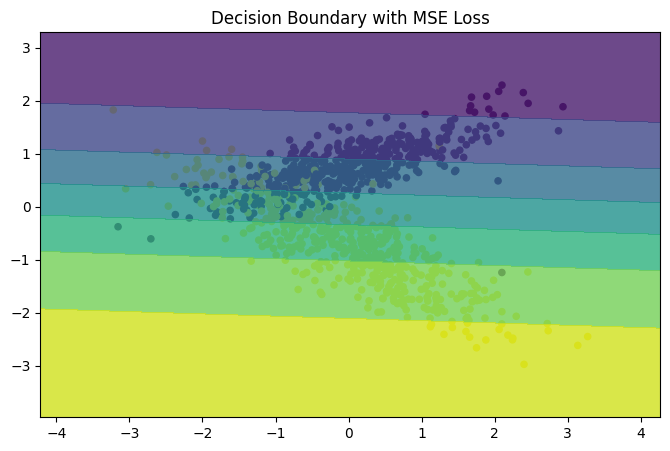

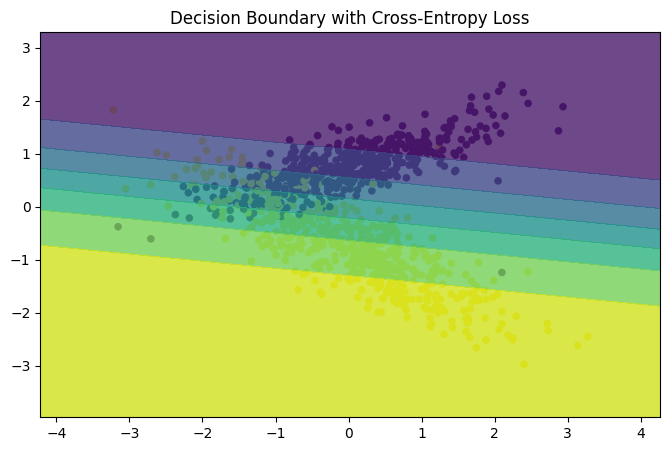

In [22]:
plot_decision_boundary(mse_model, X, y, "Decision Boundary with MSE Loss")
plot_decision_boundary(bce_model, X, y, "Decision Boundary with Cross-Entropy Loss")

In [24]:
# 计算准确率、精确率、召回率和F1分数
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
def evaluate_model(model, X, y):
    with torch.no_grad():
        preds = model(X).numpy()
        preds = (preds > 0.5).astype(int)
    accuracy = accuracy_score(y.numpy(), preds)
    precision = precision_score(y.numpy(), preds)
    recall = recall_score(y.numpy(), preds)
    f1 = f1_score(y.numpy(), preds)
    return accuracy, precision, recall, f1

print("MSE Model Evaluation:")
mse_accuracy, mse_precision, mse_recall, mse_f1 = evaluate_model(mse_model, X_test, y_test)
print(f"Accuracy: {mse_accuracy:.4f}, Precision: {mse_precision:.4f}, Recall: {mse_recall:.4f}, F1 Score: {mse_f1:.4f}")
print("Cross-Entropy Model Evaluation:")
bce_accuracy, bce_precision, bce_recall, bce_f1 = evaluate_model(bce_model, X_test, y_test)
print(f"Accuracy: {bce_accuracy:.4f}, Precision: {bce_precision:.4f}, Recall: {bce_recall:.4f}, F1 Score: {bce_f1:.4f}")

MSE Model Evaluation:
Accuracy: 0.9150, Precision: 0.9412, Recall: 0.8696, F1 Score: 0.9040
Cross-Entropy Model Evaluation:
Accuracy: 0.9300, Precision: 0.9432, Recall: 0.9022, F1 Score: 0.9222


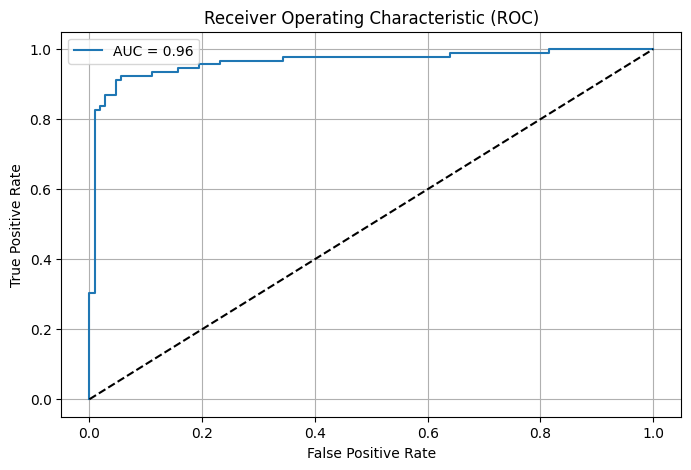

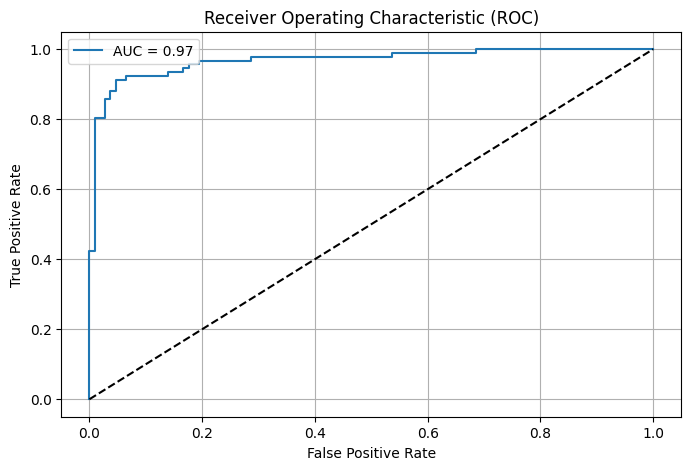

MSE Model AUC: 0.9644
Cross-Entropy Model AUC: 0.9682


In [ ]:
# 计算ROC曲线和AUC值
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, X, y):
    with torch.no_grad():
        probs = model(X).numpy()
    fpr, tpr, _ = roc_curve(y.numpy(), probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_roc_curve(mse_model, X_test, y_test)
plot_roc_curve(bce_model, X_test, y_test)
# 计算AUC值
from sklearn.metrics import roc_auc_score
def calculate_auc(model, X, y):
    with torch.no_grad():
        probs = model(X).numpy()
    auc_value = roc_auc_score(y.numpy(), probs)
    return auc_value
mse_auc = calculate_auc(mse_model, X_test, y_test)
bce_auc = calculate_auc(bce_model, X_test, y_test)
print(f"MSE Model AUC: {mse_auc:.4f}")
print(f"Cross-Entropy Model AUC: {bce_auc:.4f}")